!jt -t oceans16 -cellw 1300


# Clustering

<img src = "http://www.dispaset.eu/en/latest/_images/clustering.png" height="2000" width="750">
Source: http://www.dispaset.eu/en/latest/formulations.html?highlight=clustering

-> Three types to cluster for MIP

In [1]:
import pandas as pd
import numpy as np
import sys
import logging

In [593]:
df = pd.read_excel('plants.xlsx')

## Old Functions from Dispa-Set (corrected with faster implementation)

In [524]:
def shrink_to_64(x, N=64):
    """
    Function that reduces the length of the keys to be written to 64 (max admissible length for GAMS)

    :param x:   String or list of strings
    :param N:   Integer with the maximum string length (if different from 64)

    :returns:   Shrinked string or list of strings
    """

    def shrink_singlestring(key, N):
        if len(key) >= N:
            return key[:20] + " ... " + key[-20:]
        else:
            return key

    if type(x) == str:
        return shrink_singlestring(x, N)
    elif type(x) == list:
        return [shrink_singlestring(xx, N) for xx in x]
    else:
        logging.critical("Argument type not supported")
        sys.exit(1)


def clean_strings(x, exclude_digits=False, exclude_punctuation=False):
    """
    Function to convert strange unicode
    and remove characters punctuation

    :param x: any string or list of strings

    Usage::

        df['DisplayName'].apply(clean_strings)

    """
    if sys.version_info >= (3, 0):  # Skip this funcion if python version is >3. Have to test better TODO
        return x
    import unicodedata
    import string

    def clean_singlestring(x):
        if exclude_digits:  # modify the following depending on what you need to exclude
            exclude1 = set(string.punctuation)
            # exception to the exclusion:
            exclude1.remove("_")
            exclude1.remove("-")
            exclude1.remove("[")
            exclude1.remove("]")
        else:
            exclude1 = set([])
        if exclude_punctuation:
            exclude2 = set(string.digits)
        else:
            exclude2 = set([])
        exclude = exclude1 | exclude2

        # http://stackoverflow.com/questions/2365411/python-convert-unicode-to-ascii-without-errors
        x = str(x).decode("utf-8")  # to string byte and then unicode
        x = unicodedata.normalize("NFKD", x).encode("ascii", "ignore")  # convert utf characters and to ascii

        # x = x.upper() #to UPPERCASE
        x = "".join(ch for ch in x if ch not in exclude)  # remove numbers and punctuation
        return x

    if type(x) == str:
        return clean_singlestring(x)
    elif type(x) == list:
        return [clean_singlestring(xx) for xx in x]
    else:
        logging.error("Argument type not supported")
        sys.exit(1)


def force_str(x):
    """ Used to get a str object both in python 2 and 3 although they represent different objects (byte vs unicode)
    It is small hack for py2->3 compatibility of gams APIs which require a str object
    """
    if type(x) == str:
        return x
    else:
        return x.encode()


In [525]:
def _mylogspace(low, high, N):
    """
    Self-defined logspace function in which low and high are the first and last values of the space
    """
    # shifting all values so that low = 1
    space = np.logspace(0, np.log10(high + low + 1), N) - (low + 1)
    return space


def _find_nearest(array, value):
    """
    Self-defined function to find the index of the nearest value in a vector
    """
    idx = (np.abs(array - value)).argmin()
    return idx


In [688]:
def clustering(plants, method="Standard", Nslices=20, PartLoadMax=0.1, Pmax=30):
    """
    Merge excessively disaggregated power Units.

    :param plants:          Pandas dataframe with each power plant and their characteristics (following the DispaSET format)
    :param method:          Select clustering method ('Standard'/'LP'/None)
    :param Nslices:         Number of slices used to fingerprint each power plant characteristics. slices in the power plant data to categorize them  (fewer slices involves that the plants will be aggregated more easily)
    :param PartLoadMax:     Maximum part-load capability for the unit to be clustered
    :param Pmax:            Maximum power for the unit to be clustered
    :return:                A list with the merged plants and the mapping between the original and merged units
    """
    

    # print("Start Clustering")
    # Checking the the required columns are present in the input pandas dataframe:
    required_inputs = [
        "Unit",
        "PowerCapacity",
        "PartLoadMin",
        "RampUpRate",
        "RampDownRate",
        "StartUpTime",
        "MinUpTime",
        "MinDownTime",
        "NoLoadCost",
        "StartUpCost",
        "Efficiency",
    ]
    for input in required_inputs:
        if input not in plants.columns:
            logging.error("The plants dataframe requires a '" + input + "' column for clustering")
            sys.exit(1)
    if not "Nunits" in plants:
        plants["Nunits"] = 1

    # Checking the validity of the selected clustering method
    OnlyOnes = (plants["Nunits"] == 1).all()
    if method in ["Standard", "MILP"]:
        if not OnlyOnes:
            logging.warn(
                "The standard (or MILP) clustering method is only applicable if all values of the Nunits column in the power plant data are set to one. At least one different value has been encountered. No clustering will be applied"
            )
    elif method == "LP clustered":
        if not OnlyOnes:
            logging.warn("The LP clustering method aggregates all the units of the same type. Individual units are not considered")
            # Modifying the table to remove multiple-units plants:
            for key in ["PowerCapacity", "STOCapacity", "STOMaxChargingPower", "InitialPower", "CHPMaxHeat"]:
                if key in plants:
                    plants.loc[:, key] = plants.loc[:, "Nunits"] * plants.loc[:, key]
            plants["Nunits"] = 1
            OnlyOnes = True
    elif method == "LP":
        pass
    elif method == "Integer clustering":
        pass
    elif method == "No clustering":
        pass
    else:
        logging.error('Method argument ("' + str(method) + '") not recognized in the clustering function')
        sys.exit(1)

    # Number of units:
    Nunits = len(plants)
    plants.index = range(Nunits)

    # Definition of the mapping variable, from the old power plant list the new (merged) one:
    map_old_new = np.zeros(Nunits)
    map_plant_orig = []

    # Slicing:
    bounds = {
        "PartLoadMin": np.linspace(0, 1, Nslices),
        "RampUpRate": np.linspace(0, 1, Nslices),
        "RampDownRate": np.linspace(0, 1, Nslices),
        "StartUpTime": _mylogspace(0, 36, Nslices),
        "MinUpTime": _mylogspace(0, 168, Nslices),
        "MinDownTime": _mylogspace(0, 168, Nslices),
        "NoLoadCost": np.linspace(0, 50, Nslices),
        "StartUpCost": np.linspace(0, 500, Nslices),
        "Efficiency": np.linspace(0, 1, Nslices),
    }


    # Definition of the fingerprint value of each power plant, i.e. the pattern of the slices number in which each of
    # its characteristics falls:
    fingerprints = []
    fingerprints_merged = []
    for i in plants.index:
        fingerprints.append(
            [
                _find_nearest(bounds["PartLoadMin"], plants["PartLoadMin"][i]),
                _find_nearest(bounds["RampUpRate"], plants["RampUpRate"][i]),
                _find_nearest(bounds["RampDownRate"], plants["RampDownRate"][i]),
                _find_nearest(bounds["StartUpTime"], plants["StartUpTime"][i]),
                _find_nearest(bounds["MinUpTime"], plants["MinUpTime"][i]),
                _find_nearest(bounds["MinDownTime"], plants["MinDownTime"][i]),
                _find_nearest(bounds["NoLoadCost"], plants["NoLoadCost"][i]),
                _find_nearest(bounds["StartUpCost"], plants["StartUpCost"][i]),
                _find_nearest(bounds["Efficiency"], plants["Efficiency"][i]),
            ]
        )

    # Definition of the merged power plants dataframe:
    plants_merged = pd.DataFrame(columns=plants.columns)

    # Find the columns containing string values (in addition to "Unit")
    #    string_keys = []
    #    for i in range(len(plants.columns)):
    #        if plants.columns[i] != 'Unit' and plants.dtypes[i] == np.dtype('O'):
    #            string_keys.append(plants.columns[i])
    string_keys = ["Zone", "Technology", "Fuel", "CHPType"]
    # First, fill nan values:
    for key in string_keys:
        plants[key].fillna("", inplace=True)
        #plants[key] = df['gender'].astype('category')
    ################ PSEUDO CODE: 
    # for all i in plants_index
    #    for all j in plantsMerged_index
    #       if method
    #           for key in plants_merged
    
    
    for i in plants.index:  # i is the plant to be added to the new list
        merged = False
        highly_flexible = (
            plants["RampUpRate"][i] > 1 / 60
            and (plants["RampDownRate"][i] > 1 / 60)
            and (plants["StartUpTime"][i] < 1)
            and (plants["MinDownTime"][i] <= 1)
            and (plants["MinUpTime"][i] <= 1)
        )

        low_pmin = plants["PartLoadMin"][i] <= PartLoadMax
        low_pmax = plants["PowerCapacity"][i] <= Pmax
        P_add = plants["PowerCapacity"][i]  # Additional power to be added
        
        plants_string = plants[string_keys].iloc[i].fillna('')
        for j in plants_merged.index:  # j corresponds to the clustered plants
            
            #same_type = all([plants[key].fillna("")[i] == plants_merged[key].fillna("")[j] for key in string_keys])
            same_type = all(plants_string == plants_merged[string_keys].iloc[j].fillna(''))
            same_fingerprint = fingerprints[i] == fingerprints_merged[j]
            cluster = OnlyOnes and same_type and ((same_fingerprint and low_pmin) or highly_flexible or low_pmax)

            if method in ("Standard", "MILP") and cluster:  # merge the two plants in plants_merged:



                P_old = plants_merged["PowerCapacity"][j]  # Old power in plants_merged
                for key in plants_merged:
                    if key in [
                        "RampUpRate",
                        "RampDownRate",
                        "MinUpTime",
                        "MinDownTime",
                        "NoLoadCost",
                        "Efficiency",
                        "MinEfficiency",
                        "STOChargingEfficiency",
                        "CO2Intensity",
                        "STOSelfDischarge",
                        "CHPPowerToHeat",
                        "CHPPowerLossFactor",
                    ]:
                        # Do a weighted average:
                        plants_merged.loc[j, key] = (plants_merged[key][j] * P_old + plants[key][i] * P_add) / (P_add + P_old)
                    elif key in ["PowerCapacity", "STOCapacity", "STOMaxChargingPower", "InitialPower", "CHPMaxHeat"]:
                        # Do a sum:
                        plants_merged.loc[j, key] = plants_merged[key][j] + plants[key][i]
                    elif key in ["PartLoadMin", "StartUpTime"]:
                        # Take the minimum
                        plants_merged.loc[j, key] = np.minimum(plants_merged[key][j] * P_old, plants[key][i] * P_add) / (P_add + P_old)
                    elif key == "RampingCost":
                        # The starting cost must be added to the ramping cost
                        Cost_to_fullload = P_add * (1 - plants["PartLoadMin"][i]) * plants["RampingCost"][i] + plants["StartUpCost"][i]
                        plants_merged.loc[j, key] = (P_old * plants_merged[key][j] + Cost_to_fullload) / (P_old + P_add)
                    elif key == "Nunits":
                        plants_merged.loc[j, key] = 1
                map_old_new[i] = j
                map_plant_orig[j].append(i)
                merged = True
                break
            elif method == "LP clustered" and same_type and OnlyOnes:
                P_old = plants_merged["PowerCapacity"][j]  # Old power in plants_merged
                for key in plants_merged:
                    if key in [
                        "RampUpRate",
                        "RampDownRate",
                        "MinUpTime",
                        "MinDownTime",
                        "NoLoadCost",
                        "Efficiency",
                        "MinEfficiency",
                        "STOChargingEfficiency",
                        "CO2Intensity",
                        "STOSelfDischarge",
                    ]:
                        # Do a weighted average:
                        plants_merged.loc[j, key] = (plants_merged[key][j] * P_old + plants[key][i] * P_add) / (P_add + P_old)
                    elif key in ["PowerCapacity", "STOCapacity", "STOMaxChargingPower", "InitialPower", "CHPMaxHeat"]:
                        # Do a sum:
                        plants_merged.loc[j, key] = plants_merged[key][j] + plants[key][i]
                    elif key in ["PartLoadMin", "StartUpTime"]:
                        # impose 0
                        plants_merged.loc[j, key] = 0
                    elif key == "RampingCost":
                        # The starting cost must be added to the ramping cost
                        Cost_to_fullload = P_add * (1 - plants["PartLoadMin"][i]) * plants["RampingCost"][i] + plants["StartUpCost"][i]
                        plants_merged.loc[j, key] = (P_old * plants_merged[key][j] + Cost_to_fullload) / (P_old + P_add)
                    elif key == "Nunits":
                        plants_merged.loc[j, key] = 1
                map_old_new[i] = j
                map_plant_orig[j].append(i)
                merged = True
                break
            elif method == "Integer clustering" and same_type:
                
                for key in plants_merged:
                    if key in [
                        "PowerCapacity",
                        "RampUpRate",
                        "RampDownRate",
                        "MinUpTime",
                        "MinDownTime",
                        "NoLoadCost",
                        "Efficiency",
                        "MinEfficiency",
                        "STOChargingEfficiency",
                        "CO2Intensity",
                        "STOSelfDischarge",
                        "STOCapacity",
                        "STOMaxChargingPower",
                        "InitialPower",
                        "PartLoadMin",
                        "StartUpTime",
                        "RampingCost",
                        "CHPPowerToHeat",
                        "CHPPowerLossFactor",
                        "CHPMaxHeat",
                    ]:
                        # Do a weighted average:
                        plants_merged.loc[j, key] = (
                            plants_merged.loc[j, key] * plants_merged.loc[j, "Nunits"] + plants.loc[i, key] * plants.loc[i, "Nunits"]
                        ) / (plants_merged.loc[j, "Nunits"] + plants.loc[i, "Nunits"])
                plants_merged.loc[j, "Nunits"] = plants_merged.loc[j, "Nunits"] + plants.loc[i, "Nunits"]

                map_old_new[i] = j
                map_plant_orig[j].append(i)
                merged = True
                break

        if not merged:  # Add a new plant in plants_merged:
            plants_merged = plants_merged.append(plants.loc[i], ignore_index=True)
            plants_merged = plants_merged.copy()
            map_plant_orig.append([i])
            map_old_new[i] = len(map_plant_orig) - 1
            fingerprints_merged.append(fingerprints[i])


    Nunits_merged = len(plants_merged)
    mapping = {"NewIndex": {}, "FormerIndexes": {}}


    # Modify the Unit names with the original index number. In case of merged plants, indicate all indexes + the plant type and fuel
    for j in range(Nunits_merged):
        if len(map_plant_orig[j]) == 1:  # The plant has not been merged
            NewName = str(map_plant_orig[j]) + " - " + plants_merged["Unit"][j]
            NewName = shrink_to_64(clean_strings(NewName))
            NewName = NewName.rstrip()  # remove space at the end because it is not considered by gams
            plants_merged.loc[j, "Unit"] = NewName
            mapping["FormerIndexes"][NewName] = [map_plant_orig[j][0]]
            mapping["NewIndex"][map_plant_orig[j][0]] = NewName
        else:
            all_stringkeys = ""
            for key in string_keys:
                all_stringkeys = all_stringkeys + " - " + plants_merged[key][j]
            NewName = str(map_plant_orig[j]) + all_stringkeys
            NewName = shrink_to_64(clean_strings(NewName))
            NewName = NewName.rstrip()  # remove space at the end because it is not considered by gams
            plants_merged.loc[j, "Unit"] = NewName
            list_oldplants = [x for x in map_plant_orig[j]]
            mapping["FormerIndexes"][NewName] = list_oldplants
            for oldplant in list_oldplants:
                mapping["NewIndex"][oldplant] = NewName

    # Transforming the start-up cost into ramping for the plants that did not go through any clustering:
    if method == "LP clustered":
        for i in range(Nunits_merged):
            if plants_merged["RampingCost"][i] == 0:
                Power = plants_merged["PowerCapacity"][i]
                Start_up = plants_merged["StartUpCost"][i]
                plants_merged.loc[i, "RampingCost"] = Start_up / Power

    # Correcting the Nunits field of the clustered plants (must be integer):
    elif method == "Integer clustering":
        for idx in plants_merged.index:
            N = np.round(plants_merged.loc[idx, "Nunits"])
        for key in ["PowerCapacity", "STOCapacity", "STOMaxChargingPower", "InitialPower", "NoLoadCost"]:
            if key in plants_merged.columns:
                plants_merged.loc[idx, key] = plants_merged.loc[idx, key] * N / plants_merged.loc[idx, "Nunits"]
        plants_merged.loc[idx, "Nunits"] = N

    # Updating the index of the merged plants dataframe with the new unit names, after some cleaning:
    plants_merged.index = plants_merged["Unit"]

    if Nunits != len(plants_merged):
        logging.info("Clustered " + str(Nunits) + " original units into " + str(len(plants_merged)) + " new units")
    else:
        logging.warn("Did not cluster any unit")
    return plants_merged, mapping



In [723]:
%%time

mer1, mapping1 = clustering(df, Nslices=5, method="LP clustered")

Wall time: 11.1 s


In [709]:
df.sum()

Unit                     KW SimmeringGDK-MellachKraftwerk Thei??Malta-H...
CHPPowerToHeat                                                        None
CHPType                                                                   
CO2Intensity                                                        143.13
Efficiency                                                         256.505
Fuel                     GASGASGASWATGASGASHRDWATWATWATWATWATWATWATWATH...
MinDownTime                                                        2539.67
MinEfficiency                                                      256.505
MinUpTime                                                          3203.67
NoLoadCost                                                               0
PartLoadMin                                                          143.7
PowerCapacity                                                       395795
RampDownRate                                                       126.434
RampUpMax                

## Test of scalability

In [690]:
import time 

times = range(1,4,1)
vals = []
for i in times:
    print(i)
    start = time.time()
    mer1, mapping1 = clustering(df.append([df]*i,ignore_index=True), Nslices=5, method="Standard")
    end = time.time()
    vals.append(end-start)

1
2
3


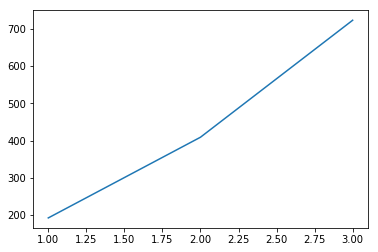

In [692]:
import matplotlib.pyplot as plt

plt.plot(times, vals)
plt.show()

In [695]:
vals

[192.39628863334656, 408.8022177219391, 722.5152966976166]

1
2
3


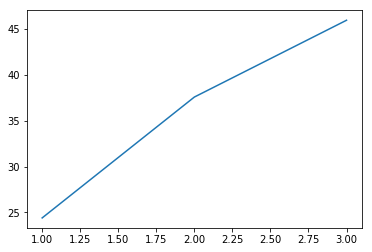

In [694]:
import time 

times_lp = range(1,4,1)
vals_lp = []
for i in times_lp:
    print(i)
    start = time.time()
    mer1, mapping1 = clustering(df.append([df]*i,ignore_index=True), Nslices=5, method="LP clustered")
    end = time.time()
    vals_lp.append(end-start)
    
plt.plot(times_lp, vals_lp)
plt.show()

Linear increase in complexity for LP, Standard probable more than $O(n)$

## New Clustering

In [749]:
def reverse_dict(dict_):
    """
    Reverse Dictionary (Key, Value) to (Value, Key)
    :param dict_:     Dictionary to reverse

    """
    new_dic = {}
    for k, v in dict_.items():
        for x in v:
            new_dic.setdefault(x, []).append(k)
    return new_dic

def split_list(list_):
    """
    Split list elements into string with " - " seperator 
    :param list_:     List to split

    """
    res = str()
    for l in list_:
        if str(l) != 'nan':
            if l != list_[-1]:
                res += str(l) + " - "
            else:
                res += str(l)
    return res

def list2dict(list_, agg): return {key: agg for key in list_} 

def flatten_list(l):
    flat_list = []
    for sublist in l:
        for item in sublist:
            flat_list.append(item)
    return flat_list

def merge_two_dicts(x, y):
    """Given two dicts, merge them into a new dict as a shallow copy.
    Used for compatibility Python 2 and 3
    inspired by: https://stackoverflow.com/questions/38987/how-to-merge-two-dictionaries-in-a-single-expression 
    """
    z = x.copy()
    z.update(y)
    return z

def get_index(df_, idx):
    res = [flatten_list(list(df_.loc[i]['FormerIndexes'].values)) for i in idx]
    return res

def create_mapping(merged_df):
    mapping = {"NewIndex": {}, "FormerIndexes": {}}
    mapping['FormerIndexes'] = merged_df['FormerIndexes'].to_dict()
    mapping['NewIndex'] = reverse_dict(mapping['FormerIndexes'])
    return mapping

def clean_df(df_merged, df_, string_keys):
    # if merged unit, create name -> else take old name for unit
    keys = ['FormerIndexes'] + string_keys
    create_unit_name = lambda x: str(x.FormerIndexes) + " - " + df_.iloc[x.FormerIndexes[0]]['Unit'] if len(x.FormerIndexes) == 1 else shrink_to_64(clean_strings(split_list(list(x[keys].values))))
    df_merged['Unit'] = df_merged.apply(create_unit_name, axis=1)
    return df_merged.set_index('Unit', drop=False)
    
    
def group_plants(plants, method, df_grouped=False, group_list = ['Zone', 'Technology', 'Fuel']):
        # Definition of the merged power plants dataframe:
        plants_merged = pd.DataFrame(columns=plants.columns)
        grouped = plants.groupby(group_list, as_index=False)
        agg_dict = create_agg_dict(plants, method=method)
        plants_merged = plants_merged.append(grouped.agg(agg_dict))
        idx = [list(i.values) for i in list(grouped.groups.values())]

        if df_grouped == False:
            idx = [list(plants.loc[i]['index'].values) for i in idx]
            plants_merged['FormerIndexes'] = idx
            
        else:
             # this must be second dataframe != index
            former_indexes = list(get_index(plants, idx))
            plants_merged['FormerIndexes'] = former_indexes

        return plants_merged

def update_unclustered_col(row, df):
    """ 
    Updates those rows which were not merged with old values
    Important when column not in grouping, but old values need to be retained
    """
    if len(row['FormerIndexes']) == 1:
        return df.ix[row['FormerIndexes'][0]]
    else:
        return row



def create_agg_dict(df_, method="Standard"):

    # lambda functions for other aggregations than standard aggregators like min/max,...
    wm_pcap = lambda x: np.average(x.astype(float), weights=df_.loc[x.index, "PowerCapacity"]) # weighted mean with wight=PowerCapacity
    wm_nunit = lambda x: np.average(x.astype(float), weights=df_.loc[x.index, "Nunits"]) # weighted mean with wight=NUnits
    get_ramping_cost = lambda x: wm_pcap((1 - df_.loc[x.index, "PartLoadMin"]) * x  + df_.loc[x.index, "StartUpCost"]/df_.loc[x.index, "PowerCapacity"])
    
    if method in ("Standard", "MILP"):
        sum_cols = ["PowerCapacity", "STOCapacity", "STOMaxChargingPower", "InitialPower", "CHPMaxHeat"]
        weighted_avg_cols = [
                        "RampUpRate",
                        "RampDownRate",
                        "MinUpTime",
                        "MinDownTime",
                        "NoLoadCost",
                        "Efficiency",
                        "MinEfficiency",
                        "STOChargingEfficiency",
                        "CO2Intensity",
                        "STOSelfDischarge",
                        "CHPPowerToHeat",
                        "CHPPowerLossFactor",
                        
                    ]
        min_cols = ["PartLoadMin", "StartUpTime"]
        ramping_cost = ["RampingCost"]
        nunits = ["Nunits"]

        # Define aggregators
        agg_dict = list2dict(sum_cols, 'sum')
        agg_dict = merge_two_dicts(agg_dict, list2dict(weighted_avg_cols, wm_pcap))
        agg_dict = merge_two_dicts(agg_dict, list2dict(min_cols, 'min'))
        agg_dict = merge_two_dicts(agg_dict, list2dict(ramping_cost, get_ramping_cost))
        agg_dict = merge_two_dicts(agg_dict, list2dict(nunits, lambda x: 1))
        agg_dict = dict((k,v) for k,v in agg_dict.items() if k in df_.columns) # remove unnecesary columns
        return agg_dict
    
    elif method == "LP clustered":
        sum_cols = ["PowerCapacity", "STOCapacity", "STOMaxChargingPower", "InitialPower", "CHPMaxHeat"]
        weighted_avg_cols = [
                                "RampUpRate",
                                "RampDownRate",
                                "MinUpTime",
                                "MinDownTime",
                                "NoLoadCost",
                                "Efficiency",
                                "MinEfficiency",
                                "STOChargingEfficiency",
                                "CO2Intensity",
                                "STOSelfDischarge"
                            ]
        min_cols = ["PartLoadMin", "StartUpTime"]
        ramping_cost = ["RampingCost"]
        nunits = ["Nunits"]

        # Define aggregators
        agg_dict = list2dict(sum_cols, 'sum')
        agg_dict = merge_two_dicts(agg_dict, list2dict(weighted_avg_cols, wm_pcap))
        agg_dict = merge_two_dicts(agg_dict, list2dict(min_cols, 'min'))
        agg_dict = merge_two_dicts(agg_dict, list2dict(ramping_cost, get_ramping_cost))
        agg_dict = merge_two_dicts(agg_dict, list2dict(nunits, lambda x: 1))
        agg_dict = dict((k,v) for k,v in agg_dict.items() if k in df_.columns) # remove unnecesary columns
        return agg_dict
    
    elif method == "Integer clustering":
        sum_cols = ["Nunits"]

        weighted_avg_cols = ['PowerCapacity','RampUpRate', 'RampDownRate', 'MinUpTime', 'MinDownTime', 'NoLoadCost', 'Efficiency',
                               'MinEfficiency', 'STOChargingEfficiency', 'CO2Intensity', 'STOSelfDischarge', 
                               'STOCapacity', 'STOMaxChargingPower','PartLoadMin', 'StartUpTime','RampingCost',
                               'CHPPowerToHeat','CHPPowerLossFactor','CHPMaxHeat']
    
        # Define aggregators

        agg_dict = list2dict(sum_cols, 'sum')
        agg_dict = merge_two_dicts(agg_dict, list2dict(weighted_avg_cols, wm_nunit))
        agg_dict = dict((k,v) for k,v in agg_dict.items() if k in df_.columns) # remove unnecesary columns
        
        return agg_dict

def clustering_new(plants, method="Standard", Nslices=20, PartLoadMax=0.1, Pmax=30):
    """
    Merge excessively disaggregated power Units.

    :param plants:          Pandas dataframe with each power plant and their characteristics (following the DispaSET format)
    :param method:          Select clustering method ('Standard'/'LP'/None)
    :param Nslices:         Number of slices used to fingerprint each power plant characteristics. slices in the power plant data to categorize them  (fewer slices involves that the plants will be aggregated more easily)
    :param PartLoadMax:     Maximum part-load capability for the unit to be clustered
    :param Pmax:            Maximum power for the unit to be clustered
    :return:                A list with the merged plants and the mapping between the original and merged units
    """

    # Checking the the required columns are present in the input pandas dataframe:
    required_inputs = ['Unit', 'PowerCapacity', 'PartLoadMin', 'RampUpRate', 'RampDownRate', 'StartUpTime',
                       'MinUpTime', 'MinDownTime', 'NoLoadCost', 'StartUpCost', 'Efficiency']
    for input_value in required_inputs:
        if input_value not in plants.columns:
            logging.error("The plants dataframe requires a '" + input_value + "' column for clustering")
            sys.exit(1)
    if not "Nunits" in plants:
        plants["Nunits"] = 1

    Nunits = len(plants)
    plants.index = range(Nunits)
    plants_merged = pd.DataFrame(columns=plants.columns)

    # Fill nan values:
    string_keys = ["Zone", "Technology", "Fuel", "CHPType"]
    for key in string_keys:
        plants[key].fillna("", inplace=True)

    # Checking the validity of the selected clustering method
    plants["index"] = plants.index

    OnlyOnes = (plants["Nunits"] == 1).all()
    if method in ["Standard", "MILP"]:
        if OnlyOnes:
            ####### Three cluster groups in the standard MILP formulation
            ###### 1) Highly flexible
            ###### 2) Low Pmin
            ###### 3) Similar characteristics --> similarity expressed via fingerprints
            # First, cluster by same string keys and flexible and low_pmin
            # Join grouped data with inflexible and no low_pmin data
            # Group joined dataframe by string keys including same technical characteristics using fingerprints
            #  The more Nslices, the more heterogenity between data, the less is merged
            # Definition of the fingerprint value of each power plant, i.e. the pattern of the slices number in which each of
            # its characteristics falls:

            # helper_cols = ['flex', 'low_pmin', 'low_pmax', 'fingerprints']
            highly_flexible = (
                (plants["RampUpRate"] > 1 / 60)
                & (plants["RampDownRate"] > 1 / 60)
                & (plants["StartUpTime"] < 1)
                & (plants["MinDownTime"] <= 1)
                & (plants["MinUpTime"] <= 1)
            )

            low_pmin = plants["PartLoadMin"] <= PartLoadMax
            plants["flex"] = highly_flexible
            plants["low_pmin"] = low_pmin
            plants["FormerIndexes"] = pd.Series(plants.index.values).apply(lambda x: [x])

            condition = (plants["low_pmin"] == True) | (plants["flex"] == True)
            first_cluster = plants[condition]  # all data without other clustering
            first_cluster = group_plants(first_cluster, method, False, string_keys)

            first_cluster = first_cluster.append(plants[~condition], ignore_index=True)
            # Slicing:
            bounds = {
                "PartLoadMin": np.linspace(0, 1, Nslices),
                "RampUpRate": np.linspace(0, 1, Nslices),
                "RampDownRate": np.linspace(0, 1, Nslices),
                "StartUpTime": _mylogspace(0, 36, Nslices),
                "MinUpTime": _mylogspace(0, 168, Nslices),
                "MinDownTime": _mylogspace(0, 168, Nslices),
                "NoLoadCost": np.linspace(0, 50, Nslices),
                "StartUpCost": np.linspace(0, 500, Nslices),
                "Efficiency": np.linspace(0, 1, Nslices),
            }

            fingerprints = []
            for i in first_cluster.index:
                fingerprints.append(
                    [
                        _find_nearest(bounds["PartLoadMin"], first_cluster["PartLoadMin"][i]),
                        _find_nearest(bounds["RampUpRate"], first_cluster["RampUpRate"][i]),
                        _find_nearest(bounds["RampDownRate"], first_cluster["RampDownRate"][i]),
                        _find_nearest(bounds["StartUpTime"], first_cluster["StartUpTime"][i]),
                        _find_nearest(bounds["MinUpTime"], first_cluster["MinUpTime"][i]),
                        _find_nearest(bounds["MinDownTime"], first_cluster["MinDownTime"][i]),
                        _find_nearest(bounds["NoLoadCost"], first_cluster["NoLoadCost"][i]),
                        _find_nearest(bounds["StartUpCost"], first_cluster["StartUpCost"][i]),
                        _find_nearest(bounds["Efficiency"], first_cluster["Efficiency"][i]),
                    ]
                )

            first_cluster["fingerprints"] = fingerprints

            # the elements of the list are irrelevant for the clustering
            first_cluster["fingerprints"] = first_cluster["fingerprints"].astype(str)
            low_pmax = first_cluster["PowerCapacity"] <= Pmax
            if first_cluster[low_pmax].empty == False:
                grouped_ = group_plants(
                    first_cluster[low_pmax], method, True, string_keys + ["fingerprints"]
                )
                plants_merged = grouped_.append(first_cluster[~low_pmax], ignore_index=True)
            else:
                plants_merged = first_cluster[:]

            plants = plants.drop(
                ["flex", "low_pmin"], axis=1
            )
            plants_merged = plants_merged.drop(
                ["index","fingerprints", "flex", "low_pmin"], axis=1
            )
        else:  # not all only ones
            logging.warn(
                "The standard (or MILP) clustering method is only applicable if all values of the Nunits column in the power plant data are set to one. At least one different value has been encountered. No clustering will be applied"
            )
        

    elif method == "LP clustered":
        if not OnlyOnes:
            logging.warn(
                "The LP clustering method aggregates all the units of the same type. Individual units are not considered"
            )
            # Modifying the table to remove multiple-units plants:
            plants[
                [
                    "PowerCapacity",
                    "STOCapacity",
                    "STOMaxChargingPower",
                    "InitialPower",
                    "CHPMaxHeat",
                ]
            ] = plants[
                [
                    "PowerCapacity",
                    "STOCapacity",
                    "STOMaxChargingPower",
                    "InitialPower",
                    "CHPMaxHeat",
                ]
            ].multiply(
                plants["Nunits"], axis="index"
            )
            plants["Nunits"] = 1
            OnlyOnes = True
        
        
        plants_merged = group_plants(plants, method="LP clustered")
        # Transforming the start-up cost into ramping for the plants that did not go through any clustering:
        ramping_lbd = (
            lambda row: row["StartUpCost"] / row["PowerCapacity"]
            if row.RampingCost == 0
            else row.RampingCost
        )
        plants_merged["RampingCost"] = plants_merged.apply(ramping_lbd, axis=1)

    elif method == "Integer clustering":
        plants_merged = group_plants(plants, method="Integer clustering")
        # Correcting the Nunits field of the clustered plants (must be integer):

    elif method == "No clustering":
        plants_merged = plants.copy()
        plants_merged["FormerIndexes"] = plants["index"].apply(lambda x: [x])

    else:
        logging.error(
            'Method argument ("' + str(method) + '") not recognized in the clustering function'
        )
        sys.exit(1)

    # clean df_
    plants_merged = clean_df(plants_merged, plants, string_keys)

    # Modify the Unit names with the original index number. In case of merged plants, indicate all indexes + the plant type and fuel
    mapping = create_mapping(plants_merged)
    if Nunits != len(plants_merged):
        logging.info(
            "Clustered "
            + str(Nunits)
            + " original units into "
            + str(len(plants_merged))
            + " new units"
        )
    else:
        logging.warn("Did not cluster any unit")
        
    plants_merged = plants_merged.apply(lambda x: update_unclustered_col(x, plants), axis=1) # use old values for plants which were not merged
    return plants_merged, mapping

In [750]:
%%time
mer2, mapping2 = clustering_new(df,  method="LP clustered")

Wall time: 322 ms


In [736]:
mer2.sum()

CHPMaxHeat                                                               0
CHPPowerLossFactor                                                       0
CHPPowerToHeat                                                           0
CO2Intensity                                                         10.37
Efficiency                                                           32.09
Fuel                     GASWATWATWATSUNBIOHRDOILWINGASWATSUNBIOHRDNUCW...
MinDownTime                                                        186.335
MinEfficiency                                                        32.09
MinUpTime                                                          232.335
NoLoadCost                                                               0
Nunits                                                                  46
PartLoadMin                                                            9.4
PowerCapacity                                                       395795
RampDownRate             

## Sort columns

In [634]:
len(mer1.columns)

28

In [635]:
len(mer2.columns)

29

In [636]:
mer1 = mer1.reindex_axis(sorted(mer1.columns), axis=1)
mer2 = mer2.reindex_axis(sorted(mer2.columns), axis=1)


## Sort index

In [570]:
#mer2 = mer2.ix[mer1.index]

## Check equality of columns

In [571]:
set(mer1.columns) - set(mer2.columns) # columns in mer1 which are not in mer2

set()

In [637]:
set(mer2.columns) - set(mer1.columns) # columns in mer2 which are not in mer1


{'FormerIndexes'}

In [638]:
del mer2['FormerIndexes']

 <font color='green'>✓ Same columns </font> 
 

## Check column sums

In [652]:
mer1.sum() 

Unit                     [0, 1, 2, 4, 5, 16,  ... - AT - COMC - GAS -[3...
CHPPowerToHeat                                                        None
CHPType                                                                   
CO2Intensity                                                         10.37
Efficiency                                                           32.09
Fuel                     GASWATHRDWATWATSUNWINBIOOILNUCWATGASBIOHRDWINS...
MinDownTime                                                        186.335
MinEfficiency                                                        32.09
MinUpTime                                                          232.335
NoLoadCost                                                               0
PartLoadMin                                                            1.8
PowerCapacity                                                       395795
RampDownRate                                                        9.6126
RampUpMax                

In [653]:
mer2.sum()

CHPMaxHeat                                                            None
CHPPowerLossFactor                                                    None
CHPPowerToHeat                                                        None
CHPType                                                               None
CO2Intensity                                                         10.37
Efficiency                                                           32.09
Fuel                     GASWATWATWATSUNBIOHRDOILWINGASWATSUNBIOHRDNUCW...
MinDownTime                                                        186.335
MinEfficiency                                                        32.09
MinUpTime                                                          232.335
NoLoadCost                                                               0
Nunits                                                                  46
PartLoadMin                                                            9.4
PowerCapacity            

Differences in 
* RampUpMax 
* RampingCost 
* StartUpCost
* StartUpTime

In [701]:
m1, _ = clustering(df, Nslices=5, method="Integer clustering")
m2, _ = clustering_new(df, Nslices=5, method="Integer clustering")